In [2]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


Load the CSV Annotations File: Load the annot.csv file containing the bounding boxes and related information:


In [3]:
annotations = pd.read_csv('TextOCR/annot.csv')
print(annotations.head())

   Unnamed: 0                  id          image_id  \
0           0  a4ea732cd3d5948a_1  a4ea732cd3d5948a   
1           1  a4ea732cd3d5948a_2  a4ea732cd3d5948a   
2           2  a4ea732cd3d5948a_3  a4ea732cd3d5948a   
3           3  a4ea732cd3d5948a_4  a4ea732cd3d5948a   
4           4  a4ea732cd3d5948a_5  a4ea732cd3d5948a   

                            bbox  utf8_string  \
0   [525.83, 3.4, 197.64, 33.94]  Performance   
1  [534.67, 64.68, 91.22, 38.19]        Sport   
2  [626.95, 63.62, 96.52, 31.82]        Watch   
3  [577.4, 141.87, 147.13, 43.1]   ...period.   
4  [391.03, 163.9, 60.82, 38.65]            .   

                                              points     area  
0  [525.83, 3.4, 723.47, 7.29, 722.76, 36.99, 525...  6707.90  
1  [535.73, 64.68, 623.41, 67.51, 625.89, 102.87,...  3483.69  
2  [626.95, 63.62, 721.7, 63.62, 723.47, 95.44, 6...  3071.27  
3  [580.02, 143.61, 724.53, 141.87, 723.66, 184.9...  6341.30  
4  [395.2, 163.9, 451.85, 191.94, 445.59, 202.55,...  

Split the data into training and validation sets

In [4]:
# Split the data into train (4000) and validation (1000)
train_df, val_df = train_test_split(annotations, train_size=4000, test_size=1000, random_state=42)
train_df.head()


,Unnamed: 0,id,image_id,bbox,utf8_string,points,area
533078,533078,8f3ed44392d0e7cd_58,8f3ed44392d0e7cd,"[702.4, 519.91, 30.32, 26.67]",Joes,"[702.4, 532.33, 725.14, 519.91, 732.72, 535.06...",808.63
835507,835507,459b300fe8d78eae_117,459b300fe8d78eae,"[304.06, 434.53, 45.24, 126.3]",.,"[317.04, 434.53, 349.3, 559.65, 334.35, 560.83...",5713.81
640318,640318,facc26ea125695b1_13,facc26ea125695b1,"[192.4, 57.33, 19.63, 22.08]",11,"[192.4, 57.33, 212.03, 57.33, 212.03, 79.41, 1...",433.43
317690,317690,9d70381f2154d262_80,9d70381f2154d262,"[273.52, 627.5, 43.24, 12.65]",LPRINT,"[273.52, 628.03, 316.49, 627.5, 316.76, 640.15...",546.99
812096,812096,0e5fee6f27d73694_10,0e5fee6f27d73694,"[259.59, 548.81, 29.03, 34.64]",10:30,"[259.59, 576.85, 275.75, 548.81, 288.62, 555.0...",1005.60


 Create a custom dataset class that handles loading images and bounding boxes:

In [16]:
class TextLocalizationDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the row for the current index
        row = self.dataframe.iloc[idx]

        # Construct the image path
        img_path = os.path.join(self.image_folder, f"{row['image_id']}.jpg")  # Assuming JPG images
        image = Image.open(img_path).convert("RGB")
        
        # Parse the bounding box points (convert from string to list)
        # The points represent the four corner coordinates [x1, y1, x2, y2, x3, y3, x4, y4]
        points = np.array(eval(row['points'])).reshape(-1, 2)  # Reshape to [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]

        if self.transform:
            image = self.transform(image)

        return image, points

In [17]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
train_dataset = TextLocalizationDataset(train_df, 'textOCR/train_val_images/train_images', transform=transform)
val_dataset = TextLocalizationDataset(val_df, 'textOCR/train_val_images/train_images', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


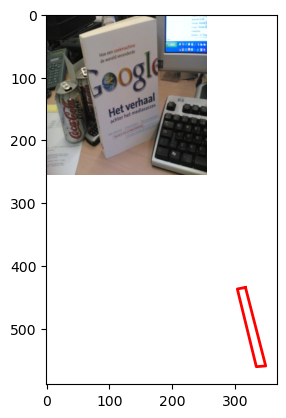

In [18]:
def visualize_sample(dataset, idx):
    image, points = dataset[idx]
    image = image.permute(1, 2, 0).numpy()  # Convert image back to (H, W, C) for visualization
    
    plt.imshow(image)
    
    # Plot the bounding box by connecting the points
    plt.plot([points[0][0], points[1][0], points[2][0], points[3][0], points[0][0]],
             [points[0][1], points[1][1], points[2][1], points[3][1], points[0][1]], 
             'r-', linewidth=2)  # Red line to connect the points
    
    plt.show()


visualize_sample(train_dataset, 1)
